# 1. Neural Network using 1 Hidden Layer

In [2]:
# Read Fashion MNIST dataset

import util_mnist_reader
import numpy as np
import random
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

X_train, y_train = util_mnist_reader.load_mnist('data/fashion', kind='train')
X_test, y_test = util_mnist_reader.load_mnist('data/fashion', kind='t10k')

# Your code goes here . . .

#splitting training data into validation and training set
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size = 0.5)

#one-hot encoding of the output
#start:
y_train1 = []
for y in y_train:
    temp = np.zeros((10, 1))
    temp[y] = 1
    y_train1.append(temp)

y_val1 = to_categorical(y_val)
y_test1 = to_categorical(y_test)
#end

In [40]:
#definig the nodes of each layer
#start:
input_node = X_train.shape[1]
hidden_node = 75
output_node = 10
#end

#initializing weights and bias
#start:
bias = [np.random.randn(hidden_node, 1), np.random.randn(output_node, 1)]
weights = [np.random.randn(hidden_node, input_node), np.random.randn(output_node, hidden_node)]
#end

#normalising the features
#start:
X_train1 = X_train / 255
X_val1 = X_val / 255
X_test1 = X_test / 255
#end

#flattening the train and test data into 1 list of [(x1, y1),(x2, y2),...(xn, yn)]
#start
Train = []
for i in range(X_train1.shape[0]):
    Train.append((X_train1[i].reshape(X_train1.shape[1], 1), y_train1[i]))

Val = []
for i in range(X_val1.shape[0]):
    Val.append((X_val1[i].reshape(X_val1.shape[1], 1), y_val1[i]))

Test = []
for i in range(X_test1.shape[0]):
    Test.append((X_test1[i].reshape(X_test1.shape[1], 1), y_test1[i]))
#end

Training_Accuracy = []
Val_Accuracy = []
Training_Loss = []
Val_Loss = []

#stochastic gradient descent
#start
def sgd(epochs, batch_size, lr, reg, train, test = None):
    n = len(train)
    for i in range(epochs):
        random.shuffle(train)
        mini_batch = [train[b : b + batch_size] for b in range(0, n, batch_size)]
        for batch in mini_batch:
            update(batch, lr, reg)
        
        Training_Loss.append(cost(train))
        Training_Accuracy.append(predict(train)/n)
        if test:
            n_test = len(test)
            Val_Loss.append(cost(test))
            prediction = predict(test)
            print("Epoch {0}: {1} / {2}".format(i+1, prediction, n_test))
            Val_Accuracy.append(prediction/n_test)
        else:
            print("Epoch {0} complete".format(i+1))
#end

#updating the mini-batch using back propagation
#start:
def update(mini_batch, rate, reg):
    n = len(mini_batch)
    
    gradient_b = [np.zeros((hidden_node, 1)), np.zeros((output_node, 1))]
    gradient_w = [np.zeros((hidden_node, input_node)), np.zeros((output_node, hidden_node))]
    
    for X, y in mini_batch:
        delta_b, delta_w = backprop(X, y)
        gradient_b = [a+b for a,b in zip(gradient_b, delta_b)]
        gradient_w = [a+b for a,b in zip(gradient_w, delta_w)]
        
    #Update rule
    global weights
    global bias
    weights = [w - ((rate/n) * (dw + (reg *w))) for w, dw in zip(weights, gradient_w)]
    bias = [b - ((rate/n) * db) for b, db in zip(bias, gradient_b)]
#end

#back-propagation
#start:
def backprop(x, y):
    activation = x
    activations = [x]
    Z = []

    gradient_b = [np.zeros((hidden_node, 1)), np.zeros((output_node, 1))]
    gradient_w = [np.zeros((hidden_node, input_node)), np.zeros((output_node, hidden_node))]
    
    ## Feedforward pass
    z = np.dot(weights[0], activation) + bias[0]
    Z.append(z)
    activation = sigmoid(z) # using sigmoid function for activation of hidden layer
    activations.append(activation)
    
    z = np.dot(weights[1], activation) + bias[1]
    Z.append(z)
    activation = softmax(z) # using softmax function for activation of output layer
    activations.append(activation)
    
    ## Backward pass
    #updating delta w[1]
    delta = (activations[-1] - y)
    gradient_b[1] = delta
    gradient_w[1] = np.dot(delta, activations[1].transpose())

    #updating delta w[0]
    derivative = sigmoid_d(activations[1])
    delta = np.dot(weights[1].transpose(), delta) * derivative
    gradient_b[0] = delta
    gradient_w[0] = np.dot(delta, activations[0].transpose())

    return (gradient_b, gradient_w)
#end

#sigmoid function
#start:
def sigmoid(z):
    return 1. / (1. + np.exp(-z))
#end

#derivative of sigmoid function
#start:
def sigmoid_d(z):
    return sigmoid(z) * (1 - sigmoid(z))
#end

#softmax function
#start:
def softmax(z):
    return np.exp(z) / np.sum(np.exp(z), axis=0)
#end

#feedforward function, calculates the output
#start:
def feedforward(a):
    i = 0
    for b, w in zip(bias, weights):
        if i == 0:
            a = sigmoid(np.dot(w, a) + b)
        else:
            a = softmax(np.dot(w, a) + b)
        i += 1
    return a
#end

#predict function, returns the number of correct predicted output wrt real output
#start:
def predict(test):
    test_results = [(np.argmax(feedforward(x)), np.argmax(y)) for (x, y) in test]
    return sum(int(x == y) for (x, y) in test_results)
#end

#cost function
#start:
def cost(data):
    y_pred = [feedforward(x) for (x, y) in data]
    y_real = [y for (x, y) in data]
    
    n_samples = len(y_real)
    loss = 0
    for pred, real in zip(y_pred, y_real):
        loss += -np.log(pred[np.argmax(real)])
    loss = loss / n_samples
    return loss
#end

epochs = 30
batch_size = 200
learning_rate = .01
lambda_reg = .001

sgd(epochs, batch_size, learning_rate, lambda_reg, Train, Val)

accuracy = predict(Test)
print('Testing Accuracy: %.2f' % (accuracy/len(Test)*100))

Epoch 1: 1644 / 5000
Epoch 2: 2361 / 5000
Epoch 3: 2648 / 5000
Epoch 4: 2827 / 5000
Epoch 5: 2947 / 5000
Epoch 6: 3057 / 5000
Epoch 7: 3127 / 5000
Epoch 8: 3199 / 5000
Epoch 9: 3232 / 5000
Epoch 10: 3284 / 5000
Epoch 11: 3318 / 5000
Epoch 12: 3327 / 5000
Epoch 13: 3336 / 5000
Epoch 14: 3322 / 5000
Epoch 15: 3353 / 5000
Epoch 16: 3393 / 5000
Epoch 17: 3406 / 5000
Epoch 18: 3423 / 5000
Epoch 19: 3437 / 5000
Epoch 20: 3455 / 5000
Epoch 21: 3474 / 5000
Epoch 22: 3487 / 5000
Epoch 23: 3500 / 5000
Epoch 24: 3507 / 5000
Epoch 25: 3517 / 5000
Epoch 26: 3529 / 5000
Epoch 27: 3561 / 5000
Epoch 28: 3569 / 5000
Epoch 29: 3560 / 5000
Epoch 30: 3569 / 5000
Testing Accuracy: 72.96


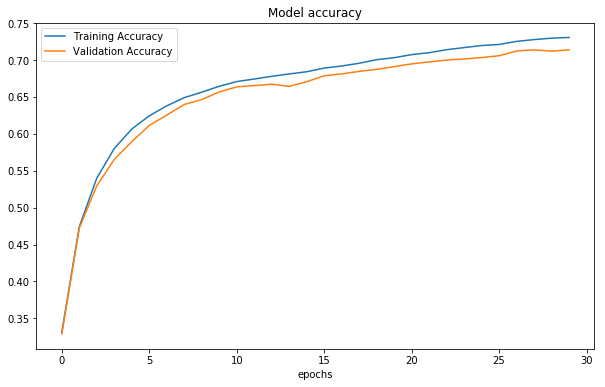

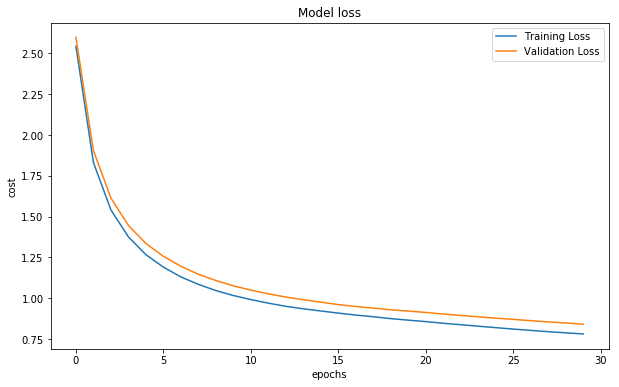

In [41]:
import matplotlib.pyplot as plt
plt.figure(1, figsize=(10, 6))
plt.title('Model accuracy')
plt.plot(Training_Accuracy, label = 'Training Accuracy')
plt.plot(Val_Accuracy, label = 'Validation Accuracy')
plt.xlabel('epochs')
plt.legend(loc = 'best')
plt.savefig("NetAccuracy.png")

plt.figure(2, figsize=(10, 6))
plt.title('Model loss')
plt.plot(Training_Loss, label = 'Training Loss')
plt.plot(Val_Loss, label = 'Validation Loss')
plt.xlabel('epochs')
plt.ylabel('cost')
plt.legend(loc = 'best')
plt.savefig("NetTraining_Loss.png")

In [42]:
predictions = [np.argmax(feedforward(x)) for (x, y) in Test]

In [43]:
from sklearn.metrics import classification_report, confusion_matrix
target_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot']
#real = [y.argmax() for y in y_test]
print('Confusion Matrix for 3 Layer Network\n')
print(confusion_matrix(y_test, predictions))

Confusion Matrix for 3 Layer Network

[[353   7   9  34   9   2  55   0  17   0]
 [ 11 462   3  25   8   0   5   0   0   0]
 [ 10   4 293   4  91   2  78   0  14   0]
 [ 37  22   9 404  23   0  18   0   4   0]
 [  4   5  97  25 303   0  55   0   8   0]
 [  2   1   0   1   2 361   4  50  22  58]
 [ 92   0  64  33  82   2 190   0  29   0]
 [  0   0   0   0   0  33   0 420  10  45]
 [ 15   0   5   6   2  12  16   5 436   2]
 [  0   0   0   0   0  20   1  39   4 426]]


In [44]:
print('Classification Report for 3 Layer Network\n')
print(classification_report(y_test, predictions, target_names = target_names))


Classification Report for 3 Layer Network

             precision    recall  f1-score   support

T-shirt/top       0.67      0.73      0.70       486
    Trouser       0.92      0.90      0.91       514
   Pullover       0.61      0.59      0.60       496
      Dress       0.76      0.78      0.77       517
       Coat       0.58      0.61      0.60       497
     Sandal       0.84      0.72      0.77       501
      Shirt       0.45      0.39      0.42       492
    Sneaker       0.82      0.83      0.82       508
        Bag       0.80      0.87      0.84       499
 Ankle Boot       0.80      0.87      0.83       490

avg / total       0.73      0.73      0.73      5000



# 2. Multi-Layer Neural Network

In [45]:
from keras.models import Sequential
from keras.layers import Dense

#define the keras model
model = Sequential()
model.add(Dense(units = 100, input_dim = 784, activation = 'relu'))
model.add(Dense(units = 50, activation = 'relu'))
model.add(Dense(units = 25, activation = 'relu'))
model.add(Dense(units = 10, activation = 'softmax'))

#compile the keras model
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

#fit the keras model on the dataset
history = model.fit(X_train, to_categorical(y_train), epochs = 30, batch_size = 128, validation_data = (X_val, y_val1))

#evaluate the keras model
_, accuracy = model.evaluate(X_test, y_test1)
print('Testing Accuracy: %.2f' % (accuracy*100))

predictions = model.predict_classes(X_test)

Train on 60000 samples, validate on 5000 samples
Epoch 1/30
60000/60000 [==============================] - 3s 44us/step - loss: 2.2177 - accuracy: 0.6704 - val_loss: 0.9182 - val_accuracy: 0.7336
Epoch 2/30
60000/60000 [==============================] - 2s 40us/step - loss: 0.7314 - accuracy: 0.7764 - val_loss: 0.6909 - val_accuracy: 0.7776
Epoch 3/30
60000/60000 [==============================] - 4s 61us/step - loss: 0.5770 - accuracy: 0.8138 - val_loss: 0.5741 - val_accuracy: 0.8142
Epoch 4/30
60000/60000 [==============================] - 4s 62us/step - loss: 0.4875 - accuracy: 0.8351 - val_loss: 0.5227 - val_accuracy: 0.8170
Epoch 5/30
60000/60000 [==============================] - 4s 72us/step - loss: 0.4278 - accuracy: 0.8497 - val_loss: 0.5487 - val_accuracy: 0.8056
Epoch 6/30
60000/60000 [==============================] - 3s 56us/step - loss: 0.4024 - accuracy: 0.8557 - val_loss: 0.4629 - val_accuracy: 0.8390
Epoch 7/30
60000/60000 [==============================] - 3s 53us/ste

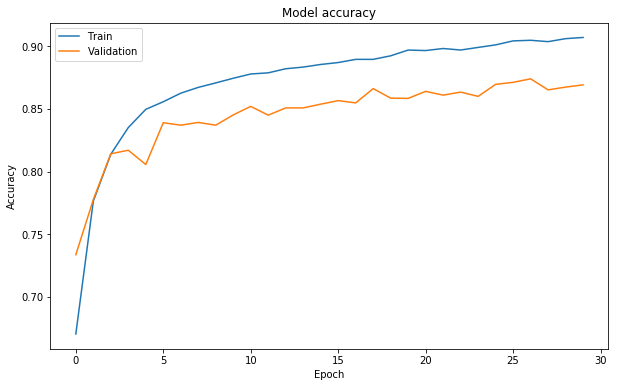

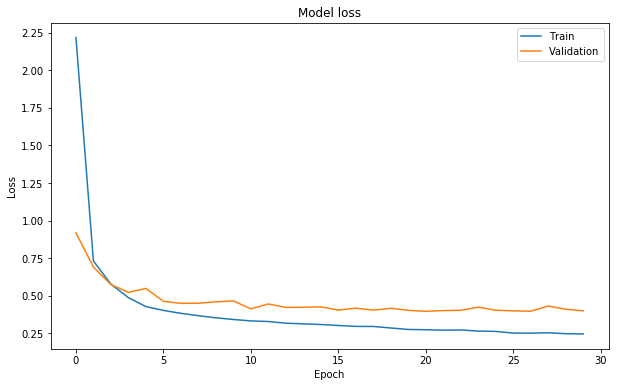

In [46]:
#Plot training & validation accuracy values
plt.figure(1, figsize=(10, 6))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='best')
plt.savefig("MultiAccuracy.png")
plt.show()

#Plot training & validation loss values
plt.figure(2, figsize=(10, 6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='best')
plt.savefig("MultiTraining_Loss.png")
plt.show()

In [47]:
#real = [y.argmax() for y in y_test1]
print('Confusion Matrix for Multi Layer Network\n')
print(confusion_matrix(y_test, predictions))

Confusion Matrix for Multi Layer Network

[[420   0  11  15   0   0  34   0   6   0]
 [  0 495   0  12   4   0   3   0   0   0]
 [  4   1 425   0  39   0  27   0   0   0]
 [ 12   8   7 465  14   0   8   0   2   1]
 [  0   0  50  23 404   0  20   0   0   0]
 [  0   0   0   0   0 478   0  10   2  11]
 [ 91   0  59  17  47   0 271   0   7   0]
 [  0   0   0   0   0   9   0 468   0  31]
 [  1   1   0   2   0   0   2   2 490   1]
 [  0   0   0   0   0   3   0   6   0 481]]


In [48]:
print('Classification Report for Multi Layer Network\n')
print(classification_report(y_test, predictions, target_names = target_names))

Classification Report for Multi Layer Network

             precision    recall  f1-score   support

T-shirt/top       0.80      0.86      0.83       486
    Trouser       0.98      0.96      0.97       514
   Pullover       0.77      0.86      0.81       496
      Dress       0.87      0.90      0.88       517
       Coat       0.80      0.81      0.80       497
     Sandal       0.98      0.95      0.96       501
      Shirt       0.74      0.55      0.63       492
    Sneaker       0.96      0.92      0.94       508
        Bag       0.97      0.98      0.97       499
 Ankle Boot       0.92      0.98      0.95       490

avg / total       0.88      0.88      0.88      5000



In [49]:
print('Summary for Multi Layer Network\n')
model.summary()

Summary for Multi Layer Network

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_13 (Dense)             (None, 100)               78500     
_________________________________________________________________
dense_14 (Dense)             (None, 50)                5050      
_________________________________________________________________
dense_15 (Dense)             (None, 25)                1275      
_________________________________________________________________
dense_16 (Dense)             (None, 10)                260       
Total params: 85,085
Trainable params: 85,085
Non-trainable params: 0
_________________________________________________________________


# CNN

In [4]:
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout

X_train = X_train.reshape(60000,28,28,1)
X_val = X_val.reshape(5000,28,28,1)
X_test = X_test.reshape(5000,28,28,1)

#create model
model = Sequential()

#add model layers
model.add(Conv2D(64, kernel_size = 2, activation = 'relu', padding = 'same', input_shape=(28,28,1)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(32, kernel_size = 2, padding = 'same', activation = 'relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
#model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
#model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

#compile model using accuracy to measure model performance
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

#fit the keras model on the dataset
history = model.fit(X_train, to_categorical(y_train), epochs = 3, batch_size = 128, validation_data = (X_val, y_val1))

#evaluate the keras model
_, accuracy = model.evaluate(X_test, y_test1)
print('Testing Accuracy: %.2f' % (accuracy*100))

predictions = model.predict_classes(X_test)

Train on 60000 samples, validate on 5000 samples
Epoch 1/3
60000/60000 [==============================] - 51s 850us/step - loss: 1.0122 - accuracy: 0.8242 - val_loss: 0.3559 - val_accuracy: 0.8680
Epoch 2/3
60000/60000 [==============================] - 51s 849us/step - loss: 0.2912 - accuracy: 0.8946 - val_loss: 0.3028 - val_accuracy: 0.8904
Epoch 3/3
5000/5000 [==============================] - 1s 293us/step
Testing Accuracy: 89.66


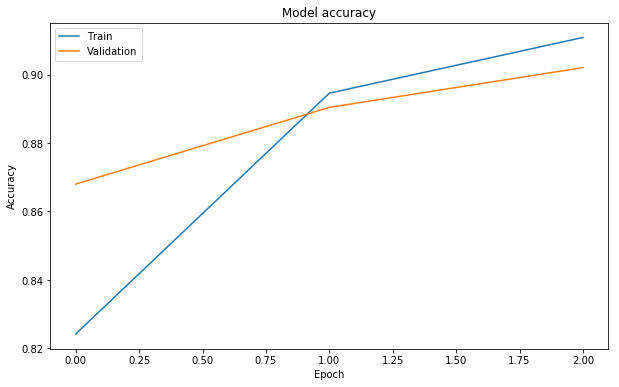

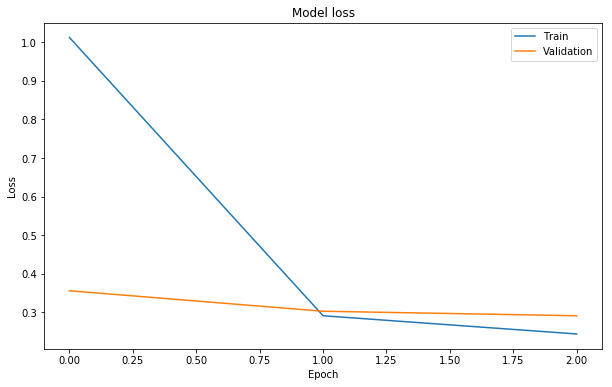

In [7]:
#Plot training & validation accuracy values
plt.figure(1, figsize=(10, 6))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='best')
plt.savefig("CNNAccuracy.png")
plt.show()

#Plot training & validation loss values
plt.figure(2, figsize=(10, 6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='best')
plt.savefig("CNNTraining_Loss.png")
plt.show()

In [9]:
print('Confusion Matrix for CNN\n')
print(confusion_matrix(y_test, predictions))

Confusion Matrix for CNN

[[409   2   4   8   1   1  80   0   2   0]
 [  0 494   0  11   0   0   2   0   1   0]
 [ 10   0 411   5  20   0  46   0   0   0]
 [  5   1   4 475  11   0  26   0   1   0]
 [  1   1  43  19 393   0  43   0   0   0]
 [  1   0   0   1   0 479   0   7   0   7]
 [ 35   1  19  19  30   0 374   0   1   0]
 [  0   0   0   0   0   2   0 482   0  11]
 [  1   1   0   5   1   1   5   0 472   0]
 [  0   0   0   0   0   4   0  17   0 494]]


In [10]:
print('Classification Report for CNN\n')
print(classification_report(y_test, predictions, target_names = target_names))

Classification Report for CNN

             precision    recall  f1-score   support

T-shirt/top       0.89      0.81      0.84       507
    Trouser       0.99      0.97      0.98       508
   Pullover       0.85      0.84      0.84       492
      Dress       0.87      0.91      0.89       523
       Coat       0.86      0.79      0.82       500
     Sandal       0.98      0.97      0.98       495
      Shirt       0.65      0.78      0.71       479
    Sneaker       0.95      0.97      0.96       495
        Bag       0.99      0.97      0.98       486
 Ankle Boot       0.96      0.96      0.96       515

avg / total       0.90      0.90      0.90      5000



In [11]:
print('Summary for CNN\n')
model.summary()

Summary for CNN

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 64)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 32)        8224      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1568)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               401664    
_________________________________________________________________
dense_2 (Dense)              (None, 1

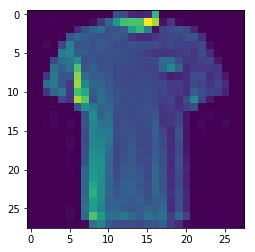

In [12]:
plt.imshow(X_train[516].reshape(28, 28))